In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scipy

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
batch_size = 32
output_nodes = 8
learning_rate = 0.01

In [4]:
train_data_path = r"C:\Users\admin\Desktop\ARTH SHAH\Emotion Challange Dataset\LP_EMO_Challenge\LP_06\Train"
val_data_path=r"C:\Users\admin\Desktop\ARTH SHAH\Emotion Challange Dataset\LP_EMO_Challenge\LP_06\Val"
test_data_path = r"C:\Users\admin\Desktop\ARTH SHAH\Emotion Challange Dataset\LP_EMO_Challenge\LP_06\Test"

In [21]:
class PtDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.files = []
        for c in self.classes:
            c_dir = os.path.join(directory, c)
            c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir)]
            self.files.extend(c_files)
        random.shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filepath, label = self.files[idx]
        try:
            mat_vals = scipy.io.loadmat(filepath)
            data = mat_vals['final']
            data=data.T
            max_len=900
            if (max_len > data.shape[0]):
                pad_width = max_len - data.shape[0]
                data = np.pad(data, pad_width=((0, pad_width),(0,0)), mode='constant')
            else:
                data = data[:max_len, :]
        except Exception as e:
            print(f"Error loading file {filepath}: {str(e)}")
            return None
        return data, label

In [22]:
train_dataset = PtDataset(train_data_path)
val_dataset = PtDataset(val_data_path)
test_dataset = PtDataset(test_data_path)

In [23]:
class PtDataLoader(DataLoader):
    def __init__(self, directory, batch_size, shuffle=True):
        dataset = PtDataset(directory)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

In [24]:
train_dataloader = PtDataLoader(directory=train_data_path, batch_size=batch_size)
val_dataloader = PtDataLoader(directory=val_data_path, batch_size=batch_size)
test_dataloader = PtDataLoader(directory=test_data_path, batch_size=batch_size)

In [25]:
train_count = len(train_dataset)
val_count = len(val_dataset)
test_count = len(test_dataset)

In [26]:
print(val_count)

15341


In [27]:
class TDNN(nn.Module):

    def __init__(
                    self,
                    input_dim,
                    output_dim,
                    context_size=5,
                    stride=1,
                    dilation=1,
                    batch_norm=False,
                    dropout_p=0.2
                ):
        super(TDNN, self).__init__()
        self.context_size = context_size
        self.stride = stride
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dilation = dilation
        self.dropout_p = dropout_p
        self.batch_norm = batch_norm

        self.kernel = nn.Linear(input_dim*context_size, output_dim)
        self.nonlinearity = nn.ReLU()
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(output_dim)
        if self.dropout_p:
            self.drop = nn.Dropout(p=self.dropout_p)

    def forward(self, x):
        '''
        input: size (batch, seq_len, input_features)
        outpu: size (batch, new_seq_len, output_features)
        '''

        _, _, d = x.shape
        assert (d == self.input_dim), 'Input dimension was wrong. Expected ({}), got ({})'.format(self.input_dim, d)
        x = x.unsqueeze(1)

        # Unfold input into smaller temporal contexts
        x = F.unfold(
                        x,
                        (self.context_size, self.input_dim),
                        stride=(1,self.input_dim),
                        dilation=(self.dilation,1)
                    )

        # N, output_dim*context_size, new_t = x.shape
        x = x.transpose(1,2)
        x = self.kernel(x.float())
        x = self.nonlinearity(x)

        if self.dropout_p:
            x = self.drop(x)

        if self.batch_norm:
            x = x.transpose(1,2)
            x = self.bn(x)
            x = x.transpose(1,2)

        return x

In [28]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F

class Classic_Attention(nn.Module):
    def __init__(self,input_dim, embed_dim, attn_dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.attn_dropout = attn_dropout
        self.lin_proj = nn.Linear(input_dim,embed_dim)
        self.v = torch.nn.Parameter(torch.randn(embed_dim))

    def forward(self,inputs):
        lin_out = self.lin_proj(inputs)
        v_view = self.v.unsqueeze(0).expand(lin_out.size(0), len(self.v)).unsqueeze(2)
        attention_weights = torch.tanh(lin_out.bmm(v_view).squeeze(2))
        attention_weights_normalized = F.softmax(attention_weights,1)
        return attention_weights_normalized

In [29]:
class Convnet(nn.Module):
    def __init__(self, input_dim = 20, num_classes=8):
        super(Convnet, self).__init__()
        ## Frame level feature processing
        self.tdnn1 = TDNN(input_dim=20, output_dim=512, context_size=5, dilation=1,dropout_p=0.2)
        self.tdnn2 = TDNN(input_dim=512, output_dim=512, context_size=5, dilation=2,dropout_p=0.2)
        self.tdnn3 = TDNN(input_dim=512, output_dim=512, context_size=7, dilation=3,dropout_p=0.2)
        self.tdnn4 = TDNN(input_dim=512, output_dim=512, context_size=1, dilation=1,dropout_p=0.2)
        self.tdnn5 = TDNN(input_dim=512, output_dim=512, context_size=1, dilation=1,dropout_p=0.2)
        ### Statistics attentive pooling
        self.attention = Classic_Attention(512,512)
        #### Frame levelPooling
        self.segment6 = nn.Linear(1024, 512)
        self.segment7 = nn.Linear(512,512 )
        self.output = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def weighted_sd(self,inputs,attention_weights, mean):
        el_mat_prod = torch.mul(inputs,attention_weights.unsqueeze(2).expand(-1,-1,inputs.shape[-1]))
        hadmard_prod = torch.mul(inputs,el_mat_prod)
        variance = torch.sum(hadmard_prod,1) - torch.mul(mean,mean)
        return variance


    def stat_attn_pool(self,inputs,attention_weights):
        el_mat_prod = torch.mul(inputs,attention_weights.unsqueeze(2).expand(-1,-1,inputs.shape[-1]))
        mean = torch.mean(el_mat_prod,1)
        variance = self.weighted_sd(inputs,attention_weights,mean)
        stat_pooling = torch.cat((mean,variance),1)
        return stat_pooling


    def forward(self, inputs):
        tdnn1_out = self.tdnn1(inputs)
        tdnn2_out = self.tdnn2(tdnn1_out)
        tdnn3_out = self.tdnn3(tdnn2_out)
        tdnn4_out = self.tdnn4(tdnn3_out)
        tdnn5_out = self.tdnn5(tdnn4_out)
        ### Stat Pool
        attn_weights = self.attention(tdnn5_out)
        stat_pool_out = self.stat_attn_pool(tdnn5_out,attn_weights)
        segment6_out = self.segment6(stat_pool_out)
        x_vec = self.segment7(segment6_out)
        predictions = self.output(x_vec)
        return predictions,x_vec

In [30]:
model = Convnet().to(device)

In [31]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [32]:
import scipy
from scipy import io

In [33]:
print(model)

Convnet(
  (tdnn1): TDNN(
    (kernel): Linear(in_features=100, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.2, inplace=False)
  )
  (tdnn2): TDNN(
    (kernel): Linear(in_features=2560, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.2, inplace=False)
  )
  (tdnn3): TDNN(
    (kernel): Linear(in_features=3584, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.2, inplace=False)
  )
  (tdnn4): TDNN(
    (kernel): Linear(in_features=512, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.2, inplace=False)
  )
  (tdnn5): TDNN(
    (kernel): Linear(in_features=512, out_features=512, bias=True)
    (nonlinearity): ReLU()
    (drop): Dropout(p=0.2, inplace=False)
  )
  (attention): Classic_Attention(
    (lin_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (segment6): Linear(in_features=1024, out_features=512, bias=True)
  (segment7): Linear(in_featu

In [34]:
#Model training and testing
n_total_steps = len(train_dataloader) # n_total_steps * batch size will give total number of training files (consider that last batch may not be fully filled)
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
max_acc=0
num_epochs = 40
pred_labels =[]
act_labels = []

for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for batch_idx, (images,labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        ##images = images.unsqueeze(1)
        optimizer.zero_grad()
        outputs=model(images)
        outputs=outputs[0]
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)


    # Evaluation on testing dataset
    model.eval()
    val_accuracy=0.0
    pred = []
    lab = []

    for i, (images,labels) in enumerate(val_dataloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        ##images = images.unsqueeze(1)
#         print(i,images.shape)
        outputs=model(images)
        outputs=outputs[0]
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))

        pred.extend(prediction.tolist())
        lab.extend(labels.tolist())

    val_accuracy=val_accuracy/val_count
    val_accuracy_list.append(val_accuracy)
    if max_acc < val_accuracy:
        max_acc = val_accuracy
        pred_labels = pred
        actual_labels = lab
        max_acc = val_accuracy
        torch.save(model,"best_accuracy_model.pth")
    print('Epoch : '+str(epoch+1)+'/'+str(num_epochs)+'   Train Loss : '+str(train_loss)+'   Train Accuracy : '+str(train_accuracy)+'   Val Accuracy : '+str(val_accuracy))
print(max_acc)
print('Finished Training and Testing')

Epoch : 1/40   Train Loss : tensor(1.5665)   Train Accuracy : 0.4665080732776383   Val Accuracy : 0.3694022553940421
Epoch : 2/40   Train Loss : tensor(1.5189)   Train Accuracy : 0.47023564230322557   Val Accuracy : 0.3694022553940421
Epoch : 3/40   Train Loss : tensor(1.5148)   Train Accuracy : 0.47017944779530213   Val Accuracy : 0.3694022553940421
Epoch : 4/40   Train Loss : tensor(1.5103)   Train Accuracy : 0.47014198479001984   Val Accuracy : 0.3694022553940421
Epoch : 5/40   Train Loss : tensor(1.5072)   Train Accuracy : 0.4707975873824598   Val Accuracy : 0.3694022553940421


KeyboardInterrupt: 

In [ ]:
torch.save(model,'mfcc_lfcc_tdnn_120.pth')

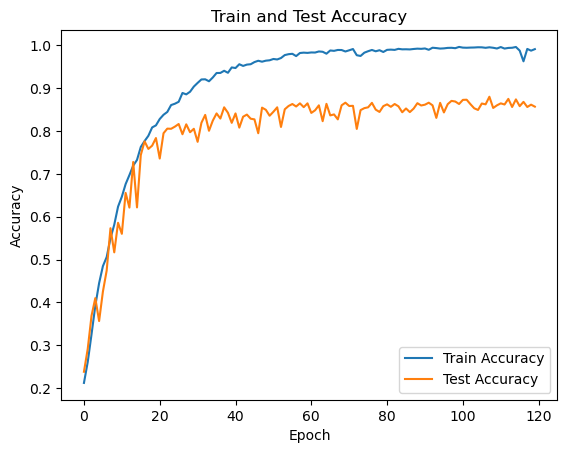

In [ ]:
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(test_accuracy_list, label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()
plt.savefig("TrainVsTest.png")
plt.show()

In [ ]:
# print("80 epoch accuracy:  Train Accuracy : 0.909472161966739   Test Accuracy : 0.8234387047031612")
# print("100 epoch accuracy: Train Accuracy : 0.9417208966015908   Test Accuracy : 0.8018504240555128")
# print("120 epoch accuracy: Train Accuracy : 0.9550735116895638   Test Accuracy : 0.8311488049344642")
# print(" 140 epoch Train Accuracy : 0.9488069414316703   Test Accuracy : 0.8496530454895914")

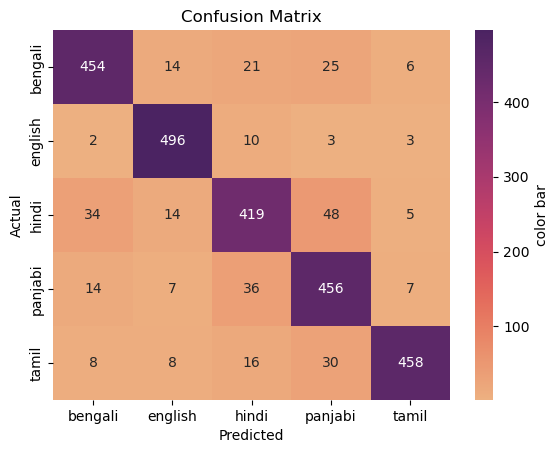

In [ ]:
# Calculate the confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(actual_labels, pred_labels)
# Plot confusion matrix heat map
sns.heatmap(conf_mat, cmap="flare",annot=True, fmt = "g",
            cbar_kws={"label":"color bar"},
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrix.png")
plt.show()

In [ ]:
# f1 = f1_score(actual_labels, pred_labels, average='weighted')
# jaccard = jaccard_score(actual_labels, pred_labels, average='weighted')
# mcc = matthews_corrcoef(actual_labels, pred_labels)
# hloss = hamming_loss(actual_labels, pred_labels)

# print(f1)
# print(jaccard)
# print(mcc)
# print(hloss)